# Data Base Project - AskReddit Dataset Analysis

**Authors :**
- Emma BASTIEN
- Marie GOARDET 
- Nathan PIZZETTA

## Create Database Structure

Load Environment Variables and OracleDB Connection

In [4]:
import polars as pl
import os
import oracledb
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

ORADB_PWD  = os.environ["ORADB_PWD"] 

OracleDB Connection

In [ ]:
# Change these parameters accordingly to match your needs
oradb_username = ""
oradb_password = ORADB_PWD
oradb_hostname = ""
oradb_port = ""
oradb_sid = ""

dsn = f"(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST={oradb_hostname})(PORT={oradb_port}))(CONNECT_DATA=(SID={oradb_sid})))"

oradb_connection = oracledb.connect(
    user=oradb_username,
    password=oradb_password,
    dsn=dsn
    )
oradb_cursor = oradb_connection.cursor()
print(oradb_connection)

<oracledb.Connection to SYSTEM@(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST=localhost)(PORT=1521))(CONNECT_DATA=(SID=FREE)))>

Table creation

In [ ]:
# Function to check if a table exists
def table_exists(table_name, cursor):
    query = f"SELECT COUNT(*) FROM USER_TABLES WHERE TABLE_NAME = UPPER('{table_name}')"
    cursor.execute(query)
    return cursor.fetchone()[0] > 0  # Returns True if table exists, False otherwise

statements = {
   "AUTHOR":
    """
        CREATE TABLE AUTHOR (
          author VARCHAR2(50) PRIMARY KEY
        )
    """,
    "DISTINGUISHED": 
    """
        CREATE TABLE DISTINGUISHED (
          distinguished VARCHAR2(50) PRIMARY KEY
        )
    """,
    "CONTROVERSY":
    """
        CREATE TABLE CONTROVERSY (
          controversiality NUMBER(1) PRIMARY KEY
        )
    """,
    "REMOVAL":
    """
        CREATE TABLE REMOVAL (
          removal_reason VARCHAR2(100) PRIMARY KEY
        )
    """,
    "SUBREDDIT":
    """
        CREATE TABLE SUBREDDIT (
          subreddit_id VARCHAR2(20) PRIMARY KEY,
          subreddit    VARCHAR2(100)
        )
    """,
    "PARENT":
    """
        CREATE TABLE PARENT (
          parent_id VARCHAR2(20) PRIMARY KEY,
          link_id   VARCHAR2(20)
        )
    """,
    "COMMENTS":
    """
        CREATE TABLE COMMENTS (
          id                      VARCHAR2(20) PRIMARY KEY,
          created_utc             NUMBER(19), 
          name                    VARCHAR2(50),
          body                    CLOB,
          edited                  NUMBER,
          author                  VARCHAR2(50),
          controversiality        NUMBER(1),
          subreddit_id            VARCHAR2(20),
          FOREIGN KEY (author) REFERENCES AUTHOR(author),
          FOREIGN KEY (controversiality) REFERENCES CONTROVERSY(controversiality),
          FOREIGN KEY (subreddit_id) REFERENCES SUBREDDIT(subreddit_id)
        )
    """,
    "SCORE":
    """
        CREATE TABLE SCORE (
          id           VARCHAR2(20) PRIMARY KEY,
          score        NUMBER,
          ups          NUMBER,
          downs        NUMBER,
          score_hidden NUMBER,
          gilded       NUMBER,
          FOREIGN KEY (id) REFERENCES COMMENTS(id)
        )
    """,
    "IS_DISTINGUISHED":
    """
        CREATE TABLE IS_DISTINGUISHED (
          id            VARCHAR2(20), 
          distinguished VARCHAR2(50),
          PRIMARY KEY (id, distinguished),
          FOREIGN KEY (id) REFERENCES COMMENTS(id),
          FOREIGN KEY (distinguished) REFERENCES DISTINGUISHED(distinguished)
        )
    """,
    "REMOVED":
    """
        CREATE TABLE REMOVED (
          id             VARCHAR2(20),
          removal_reason VARCHAR2(100),
          PRIMARY KEY(id, removal_reason), 
          FOREIGN KEY (id) REFERENCES COMMENTS(id),
          FOREIGN KEY (removal_reason) REFERENCES REMOVAL(removal_reason)
        )
    """,
    "DEPENDS":
    """
        CREATE TABLE DEPENDS (
          id         VARCHAR2(20),
          parent_id  VARCHAR2(20),
          PRIMARY KEY(id, parent_id),
          FOREIGN KEY (id) REFERENCES COMMENTS(id),
          FOREIGN KEY (parent_id) REFERENCES PARENT(parent_id)
        )
    """
}
    
for table_name, query in statements.items():
    if table_exists(table_name, oradb_cursor):
        print(f"Table '{table_name}' already exists. Skipping creation.")
    else:
        oradb_cursor.execute(query)
        print(f"Table created successfully.")

oradb_connection.commit()

Table created successfully.
Table created successfully.
Table created successfully.
Table created successfully.
Table created successfully.


## Load Data From CSV Files into Polar Dataframes

Load tables and check missing values

In [5]:
data_folder = "./data/csv_askreddit2015_split_dataset/"
dataframes = {}

# Check for nulls in all columns of each DataFrame
for table_csv in statements.keys():
    df_name = table_csv.lower()
    csv_file = os.path.join(data_folder, f"askreddit_{df_name}.csv")
    dataframes[df_name] = pl.read_csv(csv_file)
    df = dataframes[df_name]

    # Count missing values
    missing = df.select([col for col in df if col.null_count()>0]).null_count()

    # Print results with total number of rows
    print(f"Missing values in {table_csv}: {missing}")

Missing values in df_authors:
shape: (1, 0)
┌┐
╞╡
└┘
Missing values in df_comments:
shape: (1, 2)
┌────────────────────────┬───────────────────┐
│ author_flair_css_class ┆ author_flair_text │
│ ---                    ┆ ---               │
│ u32                    ┆ u32               │
╞════════════════════════╪═══════════════════╡
│ 4234970                ┆ 4234970           │
└────────────────────────┴───────────────────┘
Missing values in df_controversy:
shape: (1, 0)
┌┐
╞╡
└┘
Missing values in df_depends:
shape: (1, 0)
┌┐
╞╡
└┘
Missing values in df_distinguished:
shape: (1, 1)
┌───────────────┐
│ distinguished │
│ ---           │
│ u32           │
╞═══════════════╡
│ 1             │
└───────────────┘
Missing values in df_is_distinguished:
shape: (1, 0)
┌┐
╞╡
└┘
Missing values in df_parent:
shape: (1, 0)
┌┐
╞╡
└┘
Missing values in df_removal:
shape: (1, 0)
┌┐
╞╡
└┘
Missing values in df_removed:
shape: (1, 0)
┌┐
╞╡
└┘
Missing values in df_score:
shape: (1, 0)
┌┐
╞╡
└┘
Missing values i

Handling missing values

In [ ]:
# Comments DataFrame
dataframes["comments"] = dataframes["comments"].drop(["author_flair_css_class", "author_flair_text"])

# Distinguished DataFrame
dataframes["distinguished"] = dataframes["distinguished"].with_columns([
    pl.col(c).fill_null("Not distinguished") for c in dataframes["distinguished"].columns
])

# Is_distinguished DataFrame
df_pandas = dataframes["is_distinguished"].to_pandas()['distinguished'].replace('', 'Not distinguished')
dataframes["is_distinguished"] = pl.from_pandas(df_pandas)

*Comment*<br>
Here we see that there are missing values in `df_distinguished` and in `df_comments`.<br>
- `df_comments`: we drop the two columns with missing values, ie `author_flair_css_class` and `author_flair_text` as there are only filled with `NaN`
- `df_distinguished`: we fill the missing value by "Not distinguished" by definition.
- `df_is_distinguished`: we fill the string "" by "Not distinguished".

Check the number of rows in the csv (loaded into the dataframes)

In [6]:
results = [(name, dataframes.height) for name, dataframes in dataframes.items()]

print(f"{'DataFrame':<15}{'Rows':<10}")
print('-' * 25)
for name, row_count in results:
    print(f"{name:<15}{row_count:<10}")

DataFrame      Rows      
-------------------------
authors        570735    
comments       4234970   
controversy    2         
depends        4234970   
distinguished  3         
is_distinguished4234970   
parent         1464558   
removal        1         
removed        0         
score          4234970   
subreddit      1         


## From dataframes to database

Function to write a DataFrame to an Oracle table

In [ ]:
def write_to_db_manually(df_in:pl.DataFrame, conn, table_name, batch_size=10):
    # Get a cursor
    cursor = conn.cursor()
    columns = ",".join(df_in.columns)
    col_idx = ",".join([f":{item}" for item in df_in.columns])
    sql     = f"INSERT INTO {table_name}({columns}) VALUES ({col_idx})"
    rows = df_in.to_struct().to_list()
    cursor.executemany(sql, rows)
    conn.commit()

Writing

In [ ]:
for name, df in dataframes.items():
    name = name.upper()
    try:
        write_to_db_manually(df, oradb_connection, name)
        print(f"Loaded {len(df)} rows into {name}.")
    except oracledb.DatabaseError as db_err:
        # Handle duplicates or existing data
        error_code = db_err.args[0].code if db_err.args else None
        print(f"DatabaseError on {name} (Code={error_code}): {db_err}")
        pass
    except Exception as e:
        # Catch any other error
        print(f"Unexpected error on {name}: {e}")
        pass

In [ ]:
dataframes["removed"]

id,removal_reason
str,str


*Comment*<br>
No comments were removed in our analysis, that is why the table `REMOVED` is empty.

## Initial Database Exploration

### Overview

Describe the content of the database : what is inside each table

In [17]:
queries = [
"""
SELECT * 
FROM author 
FETCH FIRST 5 ROWS ONLY
""", 
"""
SELECT * 
FROM distinguished
""", 
"""
SELECT * 
FROM controversy
""", 
"""
SELECT * 
FROM removal
""", 
"""
SELECT * 
FROM subreddit
""",
"""
SELECT * 
FROM parent
FETCH FIRST 5 ROWS ONLY
""",
"""
SELECT * 
FROM comments
FETCH FIRST 5 ROWS ONLY
""",
"""
SELECT * 
FROM score
FETCH FIRST 5 ROWS ONLY
""",
"""
SELECT * 
FROM is_distinguished
FETCH FIRST 5 ROWS ONLY
""",
"""
SELECT * 
FROM depends
FETCH FIRST 5 ROWS ONLY
"""
]

results = {query.split()[3]: pl.read_database(query, oradb_cursor) for query in queries}

for table, df in results.items():
    print(f"\nTable: {table}")
    print(df)
    print("=" * 50) 


Table: author
shape: (5, 1)
┌────────────────┐
│ AUTHOR         │
│ ---            │
│ str            │
╞════════════════╡
│ jesse9o3       │
│ beltfedshooter │
│ InterimFatGuy  │
│ JuanTutrego    │
│ dcblackbelt    │
└────────────────┘

Table: distinguished
shape: (3, 1)
┌───────────────────┐
│ DISTINGUISHED     │
│ ---               │
│ str               │
╞═══════════════════╡
│ Not distinguished │
│ moderator         │
│ special           │
└───────────────────┘

Table: controversy
shape: (2, 1)
┌──────────────────┐
│ CONTROVERSIALITY │
│ ---              │
│ i64              │
╞══════════════════╡
│ 0                │
│ 1                │
└──────────────────┘

Table: removal
shape: (1, 1)
┌────────────────┐
│ REMOVAL_REASON │
│ ---            │
│ str            │
╞════════════════╡
│ legal          │
└────────────────┘

Table: subreddit
shape: (1, 2)
┌──────────────┬───────────┐
│ SUBREDDIT_ID ┆ SUBREDDIT │
│ ---          ┆ ---       │
│ str          ┆ str       │
╞══════════════

Information about columns (name, datatypes...) of each table

In [ ]:
queries = [
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'AUTHOR'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'DISTINGUISHED'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'CONTROVERSY'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'REMOVAL'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'SUBREDDIT'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'PARENT'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'COMMENTS'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'SCORE'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'IS_DISTINGUISHED'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'DEPENDS'"
]

for query in queries:
    oradb_cursor.execute(query)  
    rows = oradb_cursor.fetchall()  
    table_name = query.split("table_name = '")[1].split("'")[0]  
    print(f"Description of {table_name} table:")
    for row in rows:
        print(f"Column: {row[0]}, Data Type: {row[1]}")
    print("=" * 50)  

Description of AUTHOR table:
Column: AUTHOR, Data Type: VARCHAR2
Description of DISTINGUISHED table:
Column: DISTINGUISHED, Data Type: VARCHAR2
Description of CONTROVERSY table:
Column: CONTROVERSIALITY, Data Type: NUMBER
Description of REMOVAL table:
Column: REMOVAL_REASON, Data Type: VARCHAR2
Description of SUBREDDIT table:
Column: SUBREDDIT_ID, Data Type: VARCHAR2
Column: SUBREDDIT, Data Type: VARCHAR2
Description of PARENT table:
Column: PARENT_ID, Data Type: VARCHAR2
Column: LINK_ID, Data Type: VARCHAR2
Description of COMMENTS table:
Column: ID, Data Type: VARCHAR2
Column: CREATED_UTC, Data Type: NUMBER
Column: NAME, Data Type: VARCHAR2
Column: BODY, Data Type: CLOB
Column: EDITED, Data Type: NUMBER
Column: AUTHOR, Data Type: VARCHAR2
Column: CONTROVERSIALITY, Data Type: NUMBER
Column: SUBREDDIT_ID, Data Type: VARCHAR2
Description of SCORE table:
Column: ID, Data Type: VARCHAR2
Column: SCORE, Data Type: NUMBER
Column: UPS, Data Type: NUMBER
Column: DOWNS, Data Type: NUMBER
Column:

Number of rows in each table

In [10]:
queries = [
    "SELECT COUNT(*) FROM author",
    "SELECT COUNT(*) FROM distinguished",
    "SELECT COUNT(*) FROM controversy",
    "SELECT COUNT(*) FROM removal",
    "SELECT COUNT(*) FROM removed",
    "SELECT COUNT(*) FROM subreddit",
    "SELECT COUNT(*) FROM parent",
    "SELECT COUNT(*) FROM comments",
    "SELECT COUNT(*) FROM score",
    "SELECT COUNT(*) FROM is_distinguished",
    "SELECT COUNT(*) FROM depends"
]

for query in queries:
    oradb_cursor.execute(query)  
    rows = oradb_cursor.fetchall() 
    print(f"Number of rows in {query.split()[3]}: {rows[0][0]}")

Number of rows in author: 570735
Number of rows in distinguished: 3
Number of rows in controversy: 2
Number of rows in removal: 1
Number of rows in removed: 0
Number of rows in subreddit: 1
Number of rows in parent: 1464558
Number of rows in comments: 4234970
Number of rows in score: 4234970
Number of rows in is_distinguished: 4234970
Number of rows in depends: 4234970


Number of comments per day in the AskReddit subreddit

In [78]:
query = """
SELECT
  TO_CHAR(DATE '1970-01-01' + NUMTODSINTERVAL(created_utc, 'SECOND'), 'YYYY-MM-DD') AS date_day,
  COUNT(*) AS nb_comments
FROM comments
GROUP BY TO_CHAR(DATE '1970-01-01' + NUMTODSINTERVAL(created_utc, 'SECOND'), 'YYYY-MM-DD')
ORDER BY date_day """
pl.read_database(query, oradb_cursor)

DATE_DAY,NB_COMMENTS
str,i64
"""2015-05-01""",141909
"""2015-05-02""",108746
"""2015-05-03""",104064
"""2015-05-04""",129515
"""2015-05-05""",148777
…,…
"""2015-05-27""",138990
"""2015-05-28""",183461
"""2015-05-29""",186490


### COMMENTS table

Top 5 commenters (5 authors that have commented the most in 2015 in the subreddit 'AskReddit')

In [20]:
query = """
SELECT a.author, COUNT(*) AS number_of_comments
FROM comments c
JOIN author a ON a.author = c.author
GROUP BY a.author
ORDER BY number_of_comments DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

AUTHOR,NUMBER_OF_COMMENTS
str,i64
"""[deleted]""",312007
"""AutoModerator""",36910
"""Late_Night_Grumbler""",8298
"""BiagioLargo""",5843
"""-_-Equinox666-_-""",2989


*Comment*<br>

Here, we can see that the top 1 author corresponds to "[deleted]", which seems odd. We suspect that it could be an aggregation of all authors that posted during our period but who were deleted at some points.<br>

Also, the 2nd author that commented the most, "AutoModerator", if we inspect the body of its comment, seems to be a bot. All in all, to have better insights for our analysis on the real authors that commented, we exclude these two first authors. 

In [21]:
query = """
SELECT a.author, COUNT(*) AS number_of_comments
FROM comments c
JOIN author a ON a.author = c.author
GROUP BY a.author
ORDER BY number_of_comments DESC
OFFSET 2 ROWS FETCH NEXT 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

AUTHOR,NUMBER_OF_COMMENTS
str,i64
"""Late_Night_Grumbler""",8298
"""BiagioLargo""",5843
"""-_-Equinox666-_-""",2989
"""KubrickIsMyCopilot""",2601
"""Megaross""",2479


Total number of controversial comments

In [22]:
query = """
SELECT COUNT(*) AS total_controversial_comments
FROM comments c
JOIN controversy co ON c.controversiality = co.controversiality
WHERE co.controversiality = 1
"""


oradb_cursor.execute(query)

row = oradb_cursor.fetchone()
print(f"Total number of controversial comments: {row[0]}")


Total number of controversial comments: 52218


Total number of edited comments

In [23]:
query = """
SELECT COUNT(*) AS number_of_edited_comments
FROM comments
WHERE edited > 0
"""

oradb_cursor.execute(query)

row = oradb_cursor.fetchone()
print(f"Total number of edited comments: {row[0]}")

Total number of edited comments: 80620


Top 2 commenters by number of comments distinguished as "special"

In [24]:
query = """
SELECT a.author, 
    COUNT(CASE WHEN d.distinguished = 'special' THEN 1 END) AS special_comments,
    COUNT(CASE WHEN d.distinguished = 'moderator' THEN 1 END) AS moderator_comments,
    COUNT(CASE WHEN d.distinguished = 'Not distinguished' THEN 1 END) AS not_distinguished_comments
FROM comments c
JOIN author a ON c.author = a.author
JOIN is_distinguished id ON c.id = id.id
JOIN distinguished d ON id.distinguished = d.distinguished
GROUP BY a.author
ORDER BY special_comments DESC
FETCH FIRST 2 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

AUTHOR,SPECIAL_COMMENTS,MODERATOR_COMMENTS,NOT_DISTINGUISHED_COMMENTS
str,i64,i64,i64
"""kn0thing""",4,0,11
"""[deleted]""",0,0,312007


*Comment*<br>

Only one author that have been writting comments distinguished as "special" !

Top 2 commenters by number of comments distinguished as "moderator"

In [25]:
query = """
SELECT a.author, 
    COUNT(CASE WHEN d.distinguished = 'special' THEN 1 END) AS special_comments,
    COUNT(CASE WHEN d.distinguished = 'moderator' THEN 1 END) AS moderator_comments,
    COUNT(CASE WHEN d.distinguished = 'Not distinguished' THEN 1 END) AS not_distinguished_comments
FROM comments c
JOIN author a ON c.author = a.author
JOIN is_distinguished id ON c.id = id.id
JOIN distinguished d ON id.distinguished = d.distinguished
GROUP BY a.author
ORDER BY moderator_comments DESC
FETCH FIRST 2 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

AUTHOR,SPECIAL_COMMENTS,MODERATOR_COMMENTS,NOT_DISTINGUISHED_COMMENTS
str,i64,i64,i64
"""AutoModerator""",0,36907,3
"""GustavoFrings""",0,1691,562


Top 2 commenters "not distinguished"

In [29]:
query = """
SELECT a.author, 
    COUNT(CASE WHEN d.distinguished = 'special' THEN 1 END) AS special_comments,
    COUNT(CASE WHEN d.distinguished = 'moderator' THEN 1 END) AS moderator_comments,
    COUNT(CASE WHEN d.distinguished = 'Not distinguished' THEN 1 END) AS not_distinguished_comments
FROM comments c
JOIN author a ON c.author = a.author
JOIN is_distinguished id ON c.id = id.id
JOIN distinguished d ON id.distinguished = d.distinguished
GROUP BY a.author
ORDER BY not_distinguished_comments DESC
FETCH FIRST 2 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

AUTHOR,SPECIAL_COMMENTS,MODERATOR_COMMENTS,NOT_DISTINGUISHED_COMMENTS
str,i64,i64,i64
"""[deleted]""",0,0,312007
"""Late_Night_Grumbler""",0,0,8298


### SCORE table

*Comment*<br>

Visually, when investigating the dataframes, it seemed like the column downs was entirely filled with 0s, ie. meaning that apparently no thumbs down were given for all the comments we have at hand. Let us use a query to check this. 

In [88]:
query = """
SELECT
  SUM(downs) AS total_downvotes,
  CASE
    WHEN SUM(CASE WHEN downs != 0 THEN 1 ELSE 0 END) = 0 THEN 'All downs are zero'
    ELSE 'Some downs are not zero'
  END AS check_result
FROM SCORE 
"""
pl.read_database(query, oradb_cursor)

TOTAL_DOWNVOTES,CHECK_RESULT
i64,str
0,"""All downs are zero"""


*Comment*<br>

Now, we want to check if the score column corresponds exactly to the ups:

In [84]:
query = """ 
SELECT
  COUNT(*) AS total_rows,
  SUM(CASE WHEN score = ups THEN 1 ELSE 0 END) AS same_rows,
  SUM(CASE WHEN score != ups THEN 1 ELSE 0 END) AS different_rows
FROM SCORE
"""
pl.read_database(query, oradb_cursor)

TOTAL_ROWS,SAME_ROWS,DIFFERENT_ROWS
i64,i64,i64
4234970,4234970,0


*Comment*<br>

So, in the following of our analysis, we will not study the number of downs that were given since there are none and we will focus on the scores (which corresponds exactly to the number of ups)

Top 5 comments that scored the most (and if the score is hidden or not)

In [31]:
query = """
SELECT c.id, s.score, s.score_hidden
FROM score s
JOIN comments c on s.id = c.id
ORDER BY s.score DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

ID,SCORE,SCORE_HIDDEN
str,i64,i64
"""cr56nez""",6761,0
"""cr5gn52""",6736,0
"""cr3imvn""",5992,0
"""cr8p5z9""",5927,0
"""cqxx3fj""",5849,0


Top 5 authors with the highest karma in 2015 (sum of all comments' scores) / top 5 most active & influential

In [32]:
query = """
SELECT 
    a.author, 
    SUM(s.score) AS total_karma, 
    COUNT(c.id) AS total_comments, 
    ROUND(SUM(s.score) / COUNT(c.id), 2) AS average_karma
FROM comments c
JOIN author a ON c.author = a.author
JOIN score s ON c.id = s.id
GROUP BY a.author
ORDER BY total_karma DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

AUTHOR,TOTAL_KARMA,TOTAL_COMMENTS,AVERAGE_KARMA
str,i64,i64,f64
"""[deleted]""",1353042,312007,4.34
"""Donald_Keyman""",227175,312,728.13
"""kyle8998""",100898,860,117.32
"""Naweezy""",74654,69,1081.94
"""Irememberedmypw""",65769,895,73.48


Top 5 authors with the highest average karma in 2015

In [33]:
query = """
SELECT 
    a.author, 
    SUM(s.score) AS total_karma, 
    COUNT(c.id) AS total_comments, 
    ROUND(SUM(s.score) / COUNT(c.id), 2) AS average_karma
FROM comments c
JOIN author a ON c.author = a.author
JOIN score s ON c.id = s.id
GROUP BY a.author
ORDER BY average_karma DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

AUTHOR,TOTAL_KARMA,TOTAL_COMMENTS,AVERAGE_KARMA
str,i64,i64,i64
"""lenaeca""",5383,1,5383
"""CCorinne""",4836,1,4836
"""The0isaZero""",4834,1,4834
"""4eyedoracle""",4815,1,4815
"""planetoiletsscareme""",4755,1,4755


Top 5 comments that received the most reddit gold (gilded)

In [58]:
query = """
SELECT 
    c.id, 
    s.score,
    SUM(s.gilded) AS gilded_count
FROM 
    comments c 
JOIN
    score s ON c.id = s.id
WHERE 
    gilded > 0  
GROUP BY 
    c.id, s.score
ORDER BY 
    gilded_count DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

ID,SCORE,GILDED_COUNT
str,i64,i64
"""cr9xc7c""",4669,12
"""cr0ea66""",5361,11
"""crfjkeh""",2227,9
"""crcvpys""",4735,8
"""cripwvz""",4595,7


Top 5 authors that received the most reddit gold (on all 2015 comments posted)

In [35]:
query = """
SELECT 
    a.author, 
    SUM(s.gilded) AS total_gilded,
    COUNT(c.id) AS total_comments,
    ROUND(SUM(s.gilded) / COUNT(c.id), 2) AS average_nb_reddit_gold
FROM comments c
JOIN author a ON c.author = a.author
JOIN score s ON c.id = s.id
GROUP BY a.author
ORDER BY total_gilded DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

AUTHOR,TOTAL_GILDED,TOTAL_COMMENTS,AVERAGE_NB_REDDIT_GOLD
str,i64,i64,f64
"""Poem_for_your_sprog""",33,21,1.57
"""Donald_Keyman""",27,312,0.09
"""springsoon""",13,340,0.04
"""[deleted]""",12,312007,0.0
"""kyle8998""",12,860,0.01


In [36]:
query = """
SELECT 
    a.author, 
    SUM(s.gilded) AS total_gilded,
    COUNT(c.id) AS total_comments,
    ROUND(SUM(s.gilded) / COUNT(c.id), 2) AS average_nb_reddit_gold
FROM comments c
JOIN author a ON c.author = a.author
JOIN score s ON c.id = s.id
GROUP BY a.author
ORDER BY average_nb_reddit_gold DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

AUTHOR,TOTAL_GILDED,TOTAL_COMMENTS,AVERAGE_NB_REDDIT_GOLD
str,i64,i64,i64
"""GoldenScissors""",7,1,7
"""ionsevin""",3,1,3
"""Aquahawk911""",4,2,2
"""planetoiletsscareme""",2,1,2
"""DaedricDanny""",4,2,2


Top 5 most commented parent post as well as their average score associated

In [11]:
query = """ 
SELECT 
    p.parent_id,
    p.link_id, 
    COUNT(c.id) AS comment_count, 
    AVG(s.score) AS average_score
FROM COMMENTS c
JOIN DEPENDS d ON c.id = d.id
JOIN PARENT p ON d.parent_id = p.parent_id
JOIN SCORE s ON c.id = s.id
GROUP BY p.parent_id,  p.link_id
ORDER BY comment_count DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

PARENT_ID,LINK_ID,COMMENT_COUNT,AVERAGE_SCORE
str,str,i64,f64
"""t3_37pr7d""","""t3_37pr7d""",30771,2.699717
"""t3_37c2p3""","""t3_37c2p3""",11546,6.592759
"""t3_36ih74""","""t3_36ih74""",10981,11.933704
"""t3_365rlk""","""t3_365rlk""",7703,19.467091
"""t3_364iu2""","""t3_364iu2""",7558,6.954485


Counting the number of controversial and non controversial comments as well as the average score and standard deviation of the score depending on if the comments are controversial or not

In [103]:
query = """
SELECT
  co.controversiality,
  COUNT(*) AS comment_count,
  AVG(s.score) AS average_score,
  STDDEV(s.score) AS std_dev
FROM COMMENTS c
JOIN CONTROVERSY co ON c.controversiality = co.controversiality
JOIN SCORE s ON c.id = s.id
GROUP BY co.controversiality
ORDER BY co.controversiality 
"""
pl.read_database(query, oradb_cursor)

CONTROVERSIALITY,COMMENT_COUNT,AVERAGE_SCORE,STD_DEV
i64,i64,f64,f64
0,4182752,12.752865,125.273683
1,52218,0.859991,13.047647


Welch t-test of mean comparison between mean score of controversial vs mean score of non controversial comments

In [ ]:
query = """
WITH stats AS (
  SELECT
    ctr.controversiality,
    COUNT(*) AS n,
    AVG(s.score) AS mean,
    STDDEV(s.score) AS stddev
  FROM COMMENTS c
  JOIN CONTROVERSY ctr ON c.controversiality = ctr.controversiality
  JOIN SCORE s ON c.id = s.id
  GROUP BY ctr.controversiality
),
welch_test AS (
  SELECT
    a.n AS n1,
    b.n AS n2,
    a.mean AS mean1,
    b.mean AS mean2,
    a.stddev AS sd1,
    b.stddev AS sd2,
    (a.mean - b.mean) AS diff_means,
    
    SQRT(POWER(a.stddev, 2)/a.n + POWER(b.stddev, 2)/b.n) AS std_error,
    
    -- t-statistic
    (a.mean - b.mean) / SQRT(POWER(a.stddev, 2)/a.n + POWER(b.stddev, 2)/b.n) AS t_statistic,

    -- Degrees of freedom (Welch-Satterthwaite)
    POWER((POWER(a.stddev, 2)/a.n + POWER(b.stddev, 2)/b.n), 2) /
    (
      (POWER(POWER(a.stddev, 2)/a.n, 2)) / (a.n - 1) +
      (POWER(POWER(b.stddev, 2)/b.n, 2)) / (b.n - 1)
    ) AS degrees_freedom

  FROM stats a
  JOIN stats b ON a.controversiality = 1 AND b.controversiality = 0
)
SELECT
  diff_means,
  std_error,
  t_statistic,
  degrees_freedom
FROM welch_test
"""
pl.read_database(query, oradb_cursor)


DIFF_MEANS,STD_ERROR,T_STATISTIC,DEGREES_FREEDOM
f64,f64,f64,f64
-11.892874,0.083739,-142.023791,237631.813243


*Comment*<br>

A Welch’s t-test was conducted to compare the average score of controversial (controversiality = 1) and non-controversial (controversiality = 0) comments.
The test yielded a t-statistic of -142 with 237,631 degrees of freedom.
This result is highly statistically significant (p < 0.0001), indicating a very strong difference in the average score between the two groups.

## Advanced Analysis - Focus on a specific post <br>"High schoolers, what do you want to major in ? People who majored in that field, what are the pros and cons ?"<br>

Url : https://www.reddit.com/r/AskReddit/comments/37c2p3/high_schoolers_what_do_you_want_to_major_in/ <br>

*Comment* : Here we work one one hand for more advanced queries with SQL and on the other hand for text analysis with pandas.<br>

To select this post we first looked at the most commented posts and then we selected the second one because of our interest on the content of the post.

In [40]:
# Transform dataframe from polars to pandas
pd_dataframes = {}

for table in dataframes.keys():
    pd_dataframes[table] = dataframes[table].to_pandas()

In [41]:
depends = pd_dataframes["depends"]
depends_ordered = depends.groupby("parent_id").count().sort_values("id", ascending=False)
job_dream_com_ids = depends[depends["parent_id"] == "t3_37c2p3"]["id"].to_list()
depends_ordered.head(2)

,id
parent_id,
t3_37pr7d,30771
t3_37c2p3,11546


In [42]:
# Get the comments for the job_dream_com_ids
comments = pd_dataframes["comments"]
job_dream_com = comments[comments["id"].isin(job_dream_com_ids)]

# Drop deleted comments
job_dream_com = job_dream_com[job_dream_com["body"] != "[deleted]"]

# We show the first 10 comments
job_dream_com["body"].to_list()[:10]

["Accounting, I've always heard it's a safe bet\n\nThanks for the info everyone ",
 'Computer Science',
 'Some combination of electrical/computer engineering, computer science, and either philosophy/econ/Chinese',
 'In highschool I wanted to major in Computer Science, and now that I\'m in college, I\'m working with pre-law.\n\nEDIT: Looks like I need to reevaluate my classes that I signed up to be in for the Fall Semester. For the record, I am terrible at math, and that was a large variable in ditching CS.\n\nEDIT 2: Mislabeled myself. Not majoring in a dedicated "Pre-Law" course branch, I\'m really just double majoring in Criminal Justice and Philosophy.\n\n\nThanks for the input, everyone. I\'ve only just begun college, going into my second year soon. I think I still need to see where I can go.',
 "Hey! I've been thinking about a lot of choices i could possibly be majoring in. My mother say i should focus on just a few.\nRight now, i've been thinking about applying for history, chine

### SQL

Creation of the Subset in SQL

In [ ]:
query = """ 
CREATE MATERIALIZED VIEW parent_post_subset AS
SELECT parent_id, link_id
FROM PARENT
WHERE link_id = 't3_37c2p3' 
AND parent_id = 't3_37c2p3'
"""

oradb_cursor.execute(query)
oradb_cursor.connection.commit()

Top 10 Most Upvoted (comments in the subset)

In [ ]:
query = """
SELECT 
    c.id, 
    c.body, 
    s.score
FROM 
    score s
JOIN 
    comments c ON s.id = c.id
JOIN 
    depends d ON c.id = d.id  
JOIN 
    parent_post_subset pps ON d.parent_id = pps.parent_id  
ORDER BY 
    s.score DESC
FETCH FIRST 10 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

ID,BODY,SCORE
str,object,i64
"""crlfb88""","Theatre major here. Just remember, technicians work in theaters, actors work in cafes.",4579
"""crle0cg""",Ctrl + F for chemistry. 0 results. Good. Don't do it. Please see [this reply for an in depth explanation](http://www.reddit.com/r/AskReddit/comments/37c2p3/high_schoolers_what_do_you_want_to_major_in/crlgbqj),4339
"""crlgfr9""","I just wanna bring to the attention here that blue collar jobs have thriving markets and some very good pay and compensation. I myself am a pipe fitter/welder for the union and I enjoy what I do. Every day seems to be different and every job presents new challenges, yea you may get dirty, beat, bruised and banged up if you use your ass to think instead of your head (I do quite often, dont you judge me). My pay is well above most of my buddies who have completed college degrees and im almost willing to bet anything that my job satisfaction is higher. Just saying, give it some thought too. I know the go to route is college for most but for those of us who enjoy looking back and knowing we built some intricate shit that helps run even more intricate shit it's a rewarding feeling. Plus... The money. Jesus, the money. Edit: I just wanna say thank you to everyone for the overwhelming responses. I recieved multiple people asking the same questions so I did try to answer to some on my general pay (not all, so many asked lol), how to get into this trade, my personal experiences, etc. I do really appreciate the gold too! Granted I have no idea what it does lol Also I did receive a number of negative comments and I encourage people to please take a look at them as well, they did bring up valid points and I tried my best to refute some of the examples given. This isn't a life for everyone but damnit it's a good life to a lot of people. Thanks guys.",4190
"""crlddy3""",Computer Science,3427
"""crldea1""",[deleted],3067
"""crlf7ys""",ITT: My hopes and dreams being crushed.,2927
"""crlf5j9""","Just gonna jump in and say regardless of what you major in, make sure to network. Meet people! For the most part its not what you know, its who you know thats gets you the job. Edit : Also I highly encourage all of you regardless of your major to go into your professors office hours. Regardless if you need help or not. Get to know your professor this helps a lot when its time to look for job leads, letters of recommendation etc. Last edit I hope: Here is a link on how to be successful in college via networking http://www.reddit.com/r/howto/comments/37ewr1/how_to_be_successful_in_college_networking/ please let me know if it gets removed.",2468
"""crleeef""","Mechanical Engineering edit: I appreciate all the answers! If it can help narrow things down, I specifically want to work with cars. edit 2: bc I got this a bunch of times, I am committed to RIT and I will be joining their FSAE team",2184
"""crlem5l""","Cosmolgy/Astrophysics! edit: thank you so much for all the advice! I know it won't be easy but hey, no pain no gain right :P I'm actually going to work really hard on my math now after this. And if I slack, I'll just go back to this page and re-read everything.",1941


Top 10 Most Controversial (comments in the subset)

In [32]:
query = """
SELECT 
    c.id, 
    c.body, 
    s.score, 
    s.gilded, 
    co.controversiality 
FROM 
    score s
JOIN 
    comments c ON s.id = c.id
JOIN 
    depends d ON c.id = d.id 
JOIN 
    parent_post_subset pps ON d.parent_id = pps.parent_id 
JOIN 
    controversy co ON c.controversiality = co.controversiality  
WHERE 
    co.controversiality = 1 
ORDER BY 
    s.score ASC
FETCH FIRST 10 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

ID,BODY,SCORE,GILDED,CONTROVERSIALITY
str,object,i64,i64,i64
"""crle6qj""","High schoolers?!?! STOP. I didn't declare until my 3rd year in college, don't pretend you know exactly what you want to major in while you are in high school. Take a bunch of courses in college and find out what REALLY interests you. I started out Bio-Med, switched to Journalism, and eventually graduated with a Psychology degree. Also, I'm not employed in the Psychology field - always wanted to go into business with a Psych degree.",-11,0,1
"""crlg0ie""","I'm surprised I haven't seen more finance and economics majors. I did both, and now I work in the investment and insurance field on the front lines selling to the middle market. There's a negative connotation around this type of job but people out there really don't know how cool some of the financial products are out there. And it's pretty neat being able to look somebody straight in the eye and ensuring them a comfortable retirement. PS: About to venture out and start my own firm because my BD is fucking me hard. Wish me luck. :-P",-5,0,1
"""crlgpxp""",Basket Weaving. I hear it's where the money is these days.,-4,0,1
"""crlgvlf""",Napping. I feel that it is a rapidly expanding field that I can easily get into.,-3,0,1
"""crlne7e""",Dank Memes,-3,0,1
"""crlmei7""",Pussy,-2,0,1
"""crlhhid""",Can I major in telling people that college isn't required for all people.,-1,0,1
"""crlvfkr""","Currently in Grade 10, I was thinking about majoring in your mom when I graduate.",-1,0,1
"""crm1lod""",Explosive engineering? Anybody?,0,0,1


Top 10 Most Gilded (comments in the subset)

In [27]:
query = """ 
SELECT 
    c.id, 
    c.body, 
    s.score, 
    s.gilded
FROM 
    score s
JOIN 
    comments c ON s.id = c.id
JOIN 
    depends d ON c.id = d.id  
JOIN 
    parent_post_subset pps ON d.parent_id = pps.parent_id 
WHERE 
    s.gilded > 0 
ORDER BY 
    s.gilded DESC, s.score DESC
"""

pl.read_database(query, oradb_cursor)

ID,BODY,SCORE,GILDED
str,object,i64,i64
"""crlgfr9""","I just wanna bring to the attention here that blue collar jobs have thriving markets and some very good pay and compensation. I myself am a pipe fitter/welder for the union and I enjoy what I do. Every day seems to be different and every job presents new challenges, yea you may get dirty, beat, bruised and banged up if you use your ass to think instead of your head (I do quite often, dont you judge me). My pay is well above most of my buddies who have completed college degrees and im almost willing to bet anything that my job satisfaction is higher. Just saying, give it some thought too. I know the go to route is college for most but for those of us who enjoy looking back and knowing we built some intricate shit that helps run even more intricate shit it's a rewarding feeling. Plus... The money. Jesus, the money. Edit: I just wanna say thank you to everyone for the overwhelming responses. I recieved multiple people asking the same questions so I did try to answer to some on my general pay (not all, so many asked lol), how to get into this trade, my personal experiences, etc. I do really appreciate the gold too! Granted I have no idea what it does lol Also I did receive a number of negative comments and I encourage people to please take a look at them as well, they did bring up valid points and I tried my best to refute some of the examples given. This isn't a life for everyone but damnit it's a good life to a lot of people. Thanks guys.",4190,1
"""crlf5j9""","Just gonna jump in and say regardless of what you major in, make sure to network. Meet people! For the most part its not what you know, its who you know thats gets you the job. Edit : Also I highly encourage all of you regardless of your major to go into your professors office hours. Regardless if you need help or not. Get to know your professor this helps a lot when its time to look for job leads, letters of recommendation etc. Last edit I hope: Here is a link on how to be successful in college via networking http://www.reddit.com/r/howto/comments/37ewr1/how_to_be_successful_in_college_networking/ please let me know if it gets removed.",2468,1
"""crlfkan""","Electrical Engineering 😃 Edit: Wow! Thanks for all these awesome responses! Also, thanks for the gold! This all is just super cool beans. 😄",539,1
"""crlgoy0""","Just throwing this out there for high school students. Remember that there are many other careers that you do not need to go to a 4 year college for. The trades are usually seen as a low paying job, but in all reality a lot of them are starting to pay more than your college degree jobs, and are easier to get into. Just a thought you can keep in the back of your head.",453,1
"""crlegpw""","High school students, I recommend spending a few months networking in order to figure out what job you might like, and how to prepare for it. That means setting up meetings with everyone you or your parents know, and asking each person you meet for two references. Eventually you will have more references than you can count. Keep track of all of them! Keep in touch during college. If you really like someone, go back to them for mentoring. If someone seems happy in a field you might like, ask them to mentor you. You might get some summer jobs out of it, and even a lifelong career. But networking is something to do the rest of your life, regardless. And everyone remembers how difficult it was to choose a career coming out of high school, so they will be glad to meet with you. By the way, you can also meet with people who just graduated from your college and get mentoring from them.",205,1


Top 10 Most Influential Authors (in the subset)

In [28]:
query = """ 
SELECT 
    c.author, 
    COUNT(c.id) AS num_comments, 
    SUM(s.score) AS total_score
FROM 
    score s
JOIN 
    comments c ON s.id = c.id
JOIN 
    depends d ON c.id = d.id  
JOIN 
    parent_post_subset pps ON d.parent_id = pps.parent_id  
GROUP BY 
    c.author
ORDER BY 
    total_score DESC  
FETCH FIRST 10 ROWS ONLY
"""

pl.read_database(query, oradb_cursor)

AUTHOR,NUM_COMMENTS,TOTAL_SCORE
str,i64,i64
"""GregoryPippenbottom""",1,4579
"""langis_on""",1,4339
"""Lostlittlebunny""",1,4190
"""[deleted]""",719,3845
"""geoffisblind""",1,3427
"""Final_Hour""",2,3265
"""zaj209""",1,2468
"""Panzer6""",1,2184
"""Ohrianna""",1,1941


### Python<br>

Uncomment to install the required dependencies.

In [ ]:
#!pip install wordcloud spacy textblob
#!python -m spacy download en_core_web_sm

In [70]:
import nltk
import spacy
import re
from collections import Counter
from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize



# Download required NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

import en_core_web_sm
nlp = en_core_web_sm.load()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nathanpizzetta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nathanpizzetta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nathanpizzetta/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


#### Word Frequency Analysis

Functions and preprocessing

In [80]:
# Preprocess text: remove punctuation, stopwords
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word not in stop_words and len(word) > 2]  # Remove stopwords
    return words

def preprocess_text_v2(text):
    """
    Preprocess text:
    - Remove punctuation
    - Convert to lowercase
    - Extract only nouns using spaCy
    - Remove stopwords and short words (less than 3 letters)
    """
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    
    # Process text with spaCy
    doc = nlp(text)
    
    # Extract only nouns
    words = [token.text for token in doc if token.pos_ == "NOUN" and token.text not in stop_words and len(token.text) > 2]
    
    return words


# Apply preprocessing
job_dream_com["processed_text"] = job_dream_com["body"].apply(preprocess_text_v2)
job_dream_com["processed_text2"] = job_dream_com["body"].apply(preprocess_text)

# Flatten all words into a list
all_words = [word for words in job_dream_com["processed_text"] for word in words]
all_words2 = [word for words in job_dream_com["processed_text2"] for word in words]

# Count the most common words
word_freq = Counter(all_words)
word_freq2 = Counter(all_words2)

# Display top 20 words
print(word_freq.most_common(20))
print(word_freq2.most_common(20))

[('engineering', 1876), ('science', 1214), ('school', 971), ('computer', 924), ('business', 591), ('job', 563), ('college', 562), ('major', 487), ('degree', 481), ('biology', 480), ('field', 473), ('year', 410), ('design', 407), ('people', 398), ('music', 387), ('management', 327), ('law', 311), ('psychology', 304), ('finance', 296), ('work', 289)]
[('engineering', 1936), ('want', 1434), ('major', 1400), ('science', 1221), ('school', 977), ('computer', 927), ('like', 874), ('get', 745), ('would', 644), ('business', 628), ('know', 628), ('really', 620), ('work', 616), ('college', 571), ('going', 569), ('job', 563), ('high', 524), ('degree', 485), ('biology', 481), ('field', 473)]


*Comment*<br>

We can see from both approaches with nouns and verbs that words like "engineering", "science", "school" or "computer" are frequent in our subset.

Only nouns.

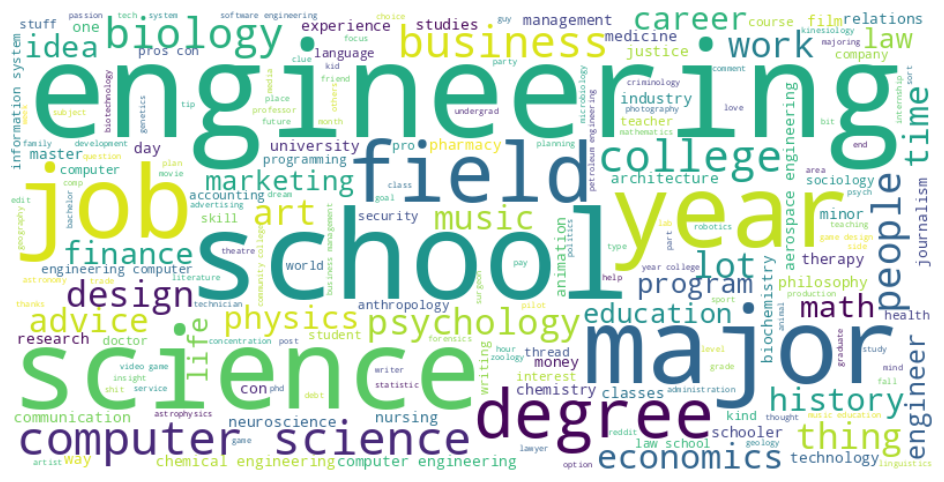

In [77]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Nouns, verbs, adjectives.

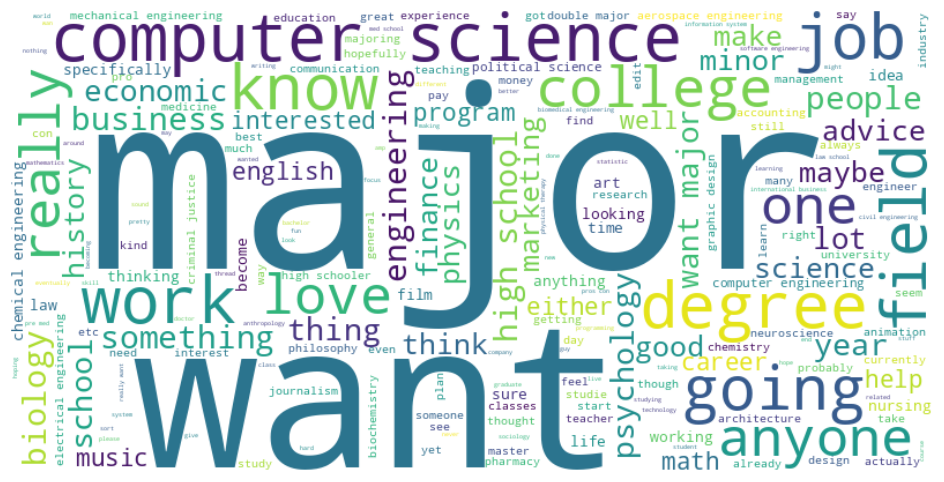

In [81]:
wordcloud2 = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words2))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Sentiment Analysis


Most Positive Comments:
                                                      body  sentiment
3419515  Industrial engineering. Basically I like busin...        1.0
3430195  Aerospace/aeronautical engineering\nAnyone got...        1.0
3434892                                     Kinesiology :D        1.0
3435908  Computer Science (software engineering honours...        1.0
3435973  Aeronautical Science, I want to be a pilot so ...        1.0

Most Negative Comments:
                                                      body  sentiment
3465283     Dentistry. I've heard terrible things from it.    -1.0000
3497217  pros of linguistics: (almost) no essays or pap...    -1.0000
3592894  Seriously don't ask me that question!! I don't...    -1.0000
3462089  Electrical engineering, or civil. I really hat...    -0.9000
3493817                 No Finance? I'm useless again! :'(    -0.8125


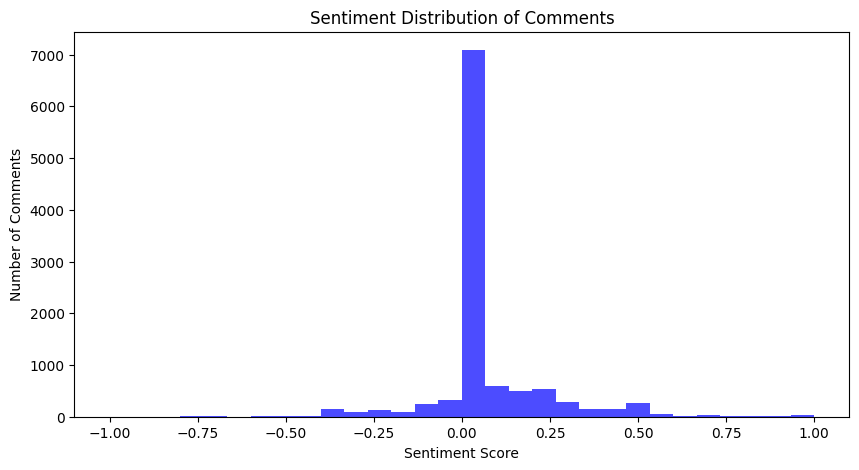

In [74]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Returns a score from -1 to 1

# Apply sentiment analysis
job_dream_com["sentiment"] = job_dream_com["body"].apply(get_sentiment)

# Display top positive and negative comments
print("\nMost Positive Comments:")
print(job_dream_com.nlargest(5, "sentiment")[["body", "sentiment"]])

print("\nMost Negative Comments:")
print(job_dream_com.nsmallest(5, "sentiment")[["body", "sentiment"]])

# Plot sentiment distribution
plt.figure(figsize=(10,5))
plt.hist(job_dream_com["sentiment"], bins=30, color="blue", alpha=0.7)
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Comments")
plt.title("Sentiment Distribution of Comments")
plt.show()

#### Named Entity Recognition (NER)

In [75]:
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ["ORG", "PERSON", "GPE", "NORP"]]

job_dream_com["entities"] = job_dream_com["body"].apply(extract_entities)

# Display most mentioned entities
entity_counts = Counter([ent for ents in job_dream_com["entities"] for ent in ents])
print("\nMost Mentioned Entities:")
print(entity_counts.most_common(10))


Most Mentioned Entities:
[('Chemical Engineering', 81), ('Computer Engineering', 72), ('Chemical', 62), ('Pros', 62), ('Aerospace Engineering', 60), ('Mechanical Engineering', 51), ('CS', 47), ('Biomedical Engineering', 45), ('Neuroscience', 42), ('Computer Science', 41)]


#### Topic Modelling with Bigram Analysis

In [78]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")
X = vectorizer.fit_transform(job_dream_com["body"])

# Get most common bigrams
bigrams = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

# Sort and display top bigrams
sorted_bigrams = sorted(bigrams.items(), key=lambda x: x[1], reverse=True)
print("\nMost Common Bigrams (Two-Word Phrases):")
print(sorted_bigrams[:10])


Most Common Bigrams (Two-Word Phrases):
[('computer science', 511), ('high school', 342), ('want major', 253), ('don know', 174), ('chemical engineering', 173), ('computer engineering', 166), ('political science', 165), ('aerospace engineering', 163), ('mechanical engineering', 152), ('electrical engineering', 143)]


#### Compare Sentiment Scores Between Majors

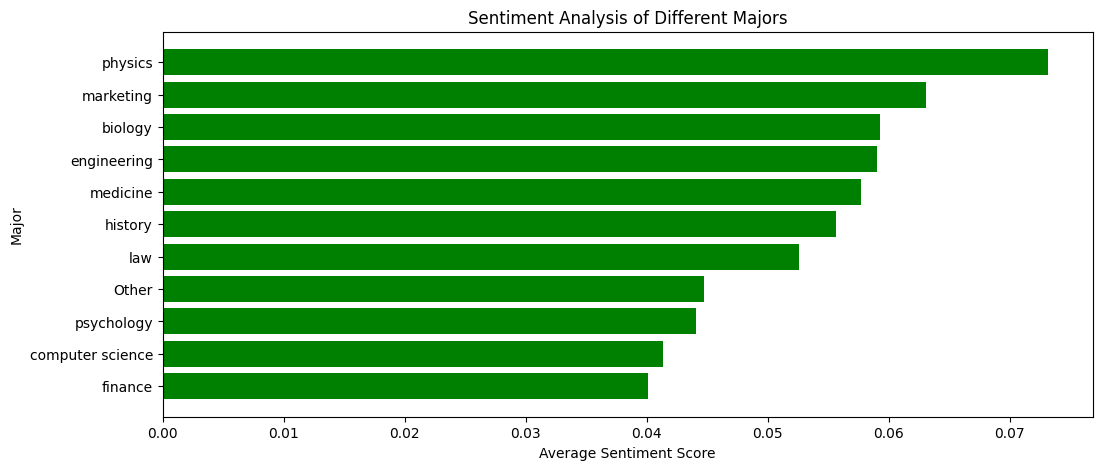

In [79]:
# Extract major fields using regex
majors_list = ["computer science", "engineering", "biology", "finance", "law", "medicine", "physics", "psychology", "marketing", "history"]

def get_major(text):
    for major in majors_list:
        if major in text.lower():
            return major
    return "Other"

job_dream_com["major"] = job_dream_com["body"].apply(get_major)

# Calculate average sentiment per major
major_sentiments = job_dream_com.groupby("major")["sentiment"].mean().sort_values()

# Plot the results
plt.figure(figsize=(12, 5))
plt.barh(major_sentiments.index, major_sentiments.values, color="green")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Major")
plt.title("Sentiment Analysis of Different Majors")
plt.show()


## Subset Creation (Database less than 5MB)

In [88]:
# Estimate the MB of the data job_dream_com
print("Estimated memory usage of our sample:", round(job_dream_com.memory_usage(deep=True).sum() / 1024 / 1024, 2), "MB")

Estimated memory usage of our sample: 4.71 MB


## Bonus : A Poem for your conveniance<br>

It comes from one of the most gilded author of our dataset : "Poem_for_your_sprog"

In [ ]:
import markdown
from IPython.display import display, HTML

poem = comments[comments["id"] == "cqy3sp9"]["body"].to_list()[0]
display(HTML(markdown.markdown(poem)))

This one was the second most gilded of his comments

In [40]:
# Show the scores on descending order for gilded
score = pd_dataframes["score"]
poem_com = comments[comments["author"] == "Poem_for_your_sprog"]
poem_com_ids = poem_com["id"].to_list()
score[score["id"].isin(poem_com_ids)].sort_values("gilded", ascending=False)

,id,score,ups,downs,score_hidden,gilded
743386,cr0ea66,5361,5361,0,0,11
437414,cqy3sp9,2599,2599,0,0,5
1681957,cr7urra,5345,5345,0,0,3
2085673,crb09rp,4850,4850,0,0,2
2484956,cre32ur,3859,3859,0,0,2
3903830,crou015,1707,1707,0,0,1
3752744,crnugu5,3293,3293,0,0,1
3572552,crmiym4,4309,4309,0,0,1
3286963,crkbtsk,1116,1116,0,0,1
2790009,crgfude,2197,2197,0,0,1
